# 초기 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [3]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

#...현재 colab의 사용량 제한으로 인해 gpu 연결이 불가능 하다고 나옵니다.... ㅠ

torch.cuda.is_available()

False

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [5]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(), # tensor로 펴준다.
                              


                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [6]:
# datasets

trainset = torchvision.datasets.CIFAR10(root='/content',
                                 train=True, download=True,
                                 transform=CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root='/content',
                                 train=False, download=True,
                                 transform=CIFAR_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [7]:
# DataLoader

# batch-size = 4

train_loader =  DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
test_loader =  DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [8]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

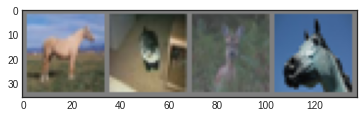

horse	 cat	 deer	 horse	


In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [31]:
class Net(nn.Module):
     def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=0)
        # in-channels = 3
        # out-channels = 6
        # kernel_size / filter-size = 3x3 -> f=3
        # stride = 1(default) -> s=1
        # padding = 0(default) -> p=0
        # input-data pixel size = 32x32 -> n=32
        # (n-f+2p)/s + 1 = new n
        # (32-3+2x0)/1 + 1 = 30
        self.maxpool1 = nn.MaxPool2d(2)
        # maxpool : n=30 -> 15

        self.conv2 = nn.Conv2d(6, 10, 3, stride = 2, padding = 1)
        # in-channels = 6 <- 이전것의 out-channels
        # out-channels = 10
        # kernel_size / filter-size = 3x3 -> f=3
        # stride = 2 -> s=2
        # padding = 1-> p=1
        # input-data pixel size = 15x15 -> n=15
        # (n-f+2p)/s + 1 = new n
        # (15-3+2x1)/2 + 1 = 8

        self.conv3 = nn.Conv2d(10,10,2, stride=1, padding=0)
        #(8-2+2x0)/1+1 = 7

        self.fc1 = nn.Linear(10 * 7 * 7, 340)
        self.fc2 = nn.Linear(340, 100)
        self.fc3 = nn.Linear(100, 10) # 10 : 10개의 category

     def forward(self, x):
        #print(x.size())
        x = F.relu(self.conv1(x))
        #print(x.size())
        x = F.max_pool2d(x, (2,2))
        #print(x.size())
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        #print(x.size())
        #x = F.max_pool2d(x, 2)
        #print(x.size())

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의
        #print(x.size())

        x = F.relu(self.fc1(x))
        #print(x.size())
        x = F.relu(self.fc2(x))
        #print(x.size())
        x = self.fc3(x)
        #print(x.size(), '\n\n')

        return x
    
     def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

net = Net()


In [32]:
myNet = Net().to(device) # gpu에 모델 저장
myNet

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=490, out_features=340, bias=True)
  (fc2): Linear(in_features=340, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [33]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [34]:
#output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [35]:
# 모델 구조 확인

summary(myNet, input_size=(3,32,32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [4, 6, 30, 30]             168
            Conv2d-2              [4, 10, 8, 8]             550
            Conv2d-3              [4, 10, 7, 7]             410
            Linear-4                   [4, 340]         166,940
            Linear-5                   [4, 100]          34,100
            Linear-6                    [4, 10]           1,010
Total params: 203,178
Trainable params: 203,178
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.21
Params size (MB): 0.78
Estimated Total Size (MB): 1.03
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [36]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

In [37]:
# epochs = 10

for epoch in range(15):
    running_loss = 0.0

    for i, data in enumerate(train_loader, start= 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()                            # 가중치 초기화

        outputs = myNet(inputs)                          # y_pred
        loss = criterion(outputs, labels)                           # 손실함수를 이용해서 loss계산
        loss.backward()                           # back-propagation
        optimizer.step()                          # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.298922381401062
Epoch: 1, Batch: 4000, Loss: 2.0512386840581893
Epoch: 1, Batch: 6000, Loss: 1.8181023099422455
Epoch: 1, Batch: 8000, Loss: 1.6504964170008898
Epoch: 1, Batch: 10000, Loss: 1.592824029237032
Epoch: 1, Batch: 12000, Loss: 1.5320089913606643
Epoch: 2, Batch: 2000, Loss: 1.4524201611056924
Epoch: 2, Batch: 4000, Loss: 1.400780993834138
Epoch: 2, Batch: 6000, Loss: 1.3827170758619904
Epoch: 2, Batch: 8000, Loss: 1.3468750884830951
Epoch: 2, Batch: 10000, Loss: 1.3207543427050115
Epoch: 2, Batch: 12000, Loss: 1.2807029163688421
Epoch: 3, Batch: 2000, Loss: 1.2165205751731991
Epoch: 3, Batch: 4000, Loss: 1.1978004663698376
Epoch: 3, Batch: 6000, Loss: 1.2027684800233691
Epoch: 3, Batch: 8000, Loss: 1.202350575529039
Epoch: 3, Batch: 10000, Loss: 1.1693516307510436
Epoch: 3, Batch: 12000, Loss: 1.1990705211982131
Epoch: 4, Batch: 2000, Loss: 1.0808294683881103
Epoch: 4, Batch: 4000, Loss: 1.0815183450579644
Epoch: 4, Batch: 6000, Loss: 1.0709975

## 모델의 저장 및 로드

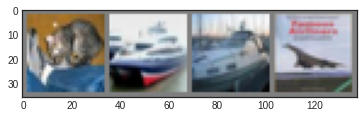

	cat 	ship 	ship 	plane


In [38]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [39]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [24]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [40]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)                                              # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                                             # y_pred
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

60.87


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [41]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 62.4%
Accuracy of car: 68.3%
Accuracy of bird: 47.5%
Accuracy of cat: 36.7%
Accuracy of deer: 59.4%
Accuracy of dog: 47.4%
Accuracy of frog: 77.0%
Accuracy of horse: 65.9%
Accuracy of ship: 73.0%
Accuracy of truck: 71.1%


In [42]:
#이놈의 개랑 고양이가 구별이 안되서 70%를 못넘기겠습니다.....!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!